<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_1_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Neural networks and back propagation for binary classification

In [ ]:
# import required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
# create data
XX, YY = make_moons(n_samples=1000, noise=.2, random_state=41)
with open('ex1.csv','w') as f:
    f.writelines('%f,%f,%f\n'%(x[0],x[1],y) for x,y in zip (XX,YY))

In [ ]:
# load data
data = np.genfromtxt('ex1.csv', delimiter=',')
num_examples = len(data)
print(num_examples)

1000


In [ ]:
# randomize data and split to train and test
np.random.seed(42)
np.random.shuffle(data)

split = int(num_examples*0.8)
train = data[:split]
test = data[split:]
print(train.shape, test.shape)
print(train[:5])

(800, 3) (200, 3)
[[-0.25666   0.941459  0.      ]
 [ 1.673439 -0.476619  1.      ]
 [ 0.964778  0.428332  0.      ]
 [ 1.181203  0.060972  0.      ]
 [ 1.487823 -0.693376  1.      ]]


(800, 2) (200, 2)
(800,) (200,)


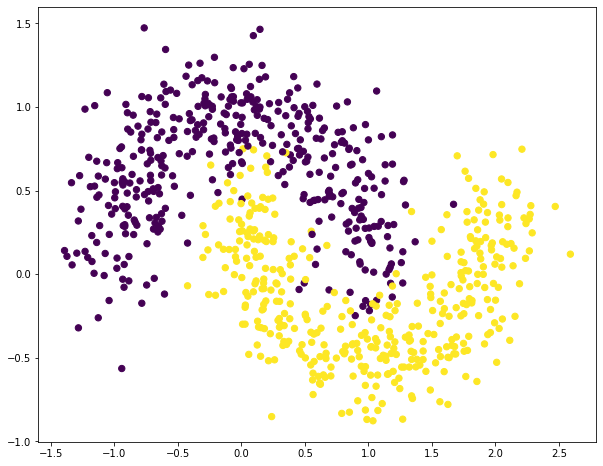

In [ ]:
# get features and labels
X_train, y_train = train[:,:2], train[:,2]
X_test, y_test = test[:,:2], test[:,2]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# visulize the training set
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train)

In [ ]:
#setup weight martices and initialize
def init_weights(num_input_nodes, num_output_nodes):
    return np.random.uniform(low=-1, high=1, size=(num_input_nodes, num_output_nodes))

In [ ]:
#implement sigmoid function
def sigmoid(z):
    #your code here:
    ret = 1/(1+np.exp(-z))
    
    return ret

In [ ]:
#implement cross entropy
def cross_entropy(H, y):
    #your code here:
    ret = -np.log(H+1e-10)*y-np.log(1-H+1e-10)*(1-y)
    
    return ret

In [ ]:
def is_correct(H, y):
    #your code here:
    ret = (H>=0.5) == y
    return ret

In [ ]:
#implement layer - compute values at output of layer (after sigmoid activation)
def compute_layer(inputs_to_layer, weights):
    #your code here:
    ret = sigmoid(weights.T@inputs_to_layer)
    
    return ret

In [ ]:
def forward_pass(x, w, m):
    x = np.expand_dims(x, axis=-1)
    h = compute_layer(x, w)
    h = np.vstack((np.ones((1,1)), h)) # added a constant hidden node for bias calculations
    H = compute_layer(h, m)[0,0]
    return x,h,H

In [ ]:
def backward_pass(x, h, H, y, m):
    #your code here:
    djdm = (H-y)*h
    djdw = (djdm*m*(1-h))[1:].T*x # 1: to ignore bias term
    return djdm, djdw

In [ ]:
def train(features, labels, num_epochs, num_hidden_nodes, learning_rate):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    num_examples, num_features = features.shape
    w = init_weights(num_features, num_hidden_nodes)
    m = init_weights(num_hidden_nodes+1, 1) # +1 to allow bias calculations
    for i in range(num_epochs):
        loss = 0
        count_correct = 0
        sum_djdm = 0
        sum_djdw = 0
        for x, y in zip(features, labels):
            x, h, H = forward_pass(x, w, m)
            loss += cross_entropy(H, y)
            count_correct += is_correct(H, y)
            djdm, djdw = backward_pass(x, h, H, y, m)
            sum_djdm += djdm
            sum_djdw += djdw
        m -= learning_rate*sum_djdm/num_examples
        w -= learning_rate*sum_djdw/num_examples
        if (i+1)%100==0:
            print(i+1, loss/num_examples, count_correct/num_examples)
    return w, m

In [ ]:
def test(features, labels, w, m):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    num_examples, num_features = features.shape
    loss = 0
    count_correct = 0
    for x, y in zip(features, labels):
        x, h, H = forward_pass(x, w, m)
        loss += cross_entropy(H, y)
        count_correct += is_correct(H, y)
    return loss/num_examples, count_correct/num_examples

In [ ]:
def predict(features, w, m):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    pred = []
    for x in features:
        x, h, H = forward_pass(x, w, m)
        pred.append(1 if H>=0.5 else 0)
    return np.array(pred)
    

In [ ]:
def get_probs(features, w, m):
    features = np.hstack((np.ones((len(features),1)), features)) # added a constant input node for bias calculations
    prob = []
    for x in features:
        x, h, H = forward_pass(x, w, m)
        prob.append(H)
    return np.array(prob)

In [ ]:
# Decision boundary visualization

def plot_decision_boundary(features, labels, w, m):
    # Set min and max values and give it some padding
    x_min, x_max = features[:, 0].min() - .5, features[:, 0].max() + .5
    y_min, y_max = features[:, 1].min() - .5, features[:, 1].max() + .5
    
    # Generate a grid of points with distance h between them
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                         np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    g = predict(np.c_[xx.ravel(), yy.ravel()], w, m)
    g = g.reshape(xx.shape)
    
    # Plot the contour and test examples
    plt.contourf(xx, yy, g, cmap=plt.cm.Spectral)
    plt.scatter(features[:, 0], features[:, 1], s=40, c=labels)

100 0.6468568799162394 0.78875
200 0.5847976029854235 0.7875
300 0.5180101112628198 0.8025

test: 0.5093667059969339 0.825


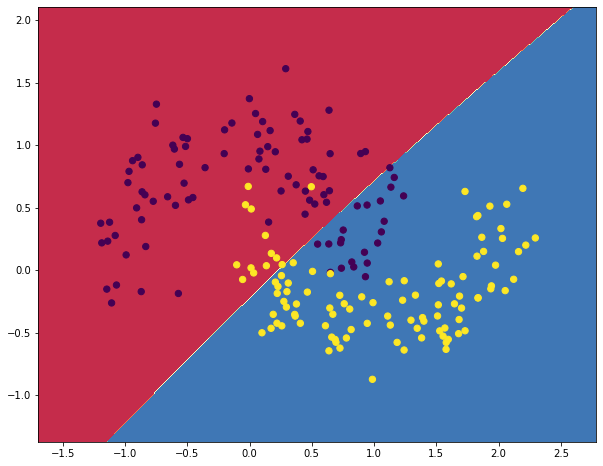

In [ ]:
# what do you think about the following results?
w,m = train(X_train, y_train, num_epochs=300, num_hidden_nodes=2, learning_rate=0.1)
loss,acc = test(X_test, y_test, w, m)
print ('\ntest:',loss,acc)
plot_decision_boundary(X_test, y_test, w, m)

100 0.1537297663677368 0.95125
200 0.09452124774616051 0.9675
300 0.08806811554671876 0.96875
400 0.08581722058654244 0.96875
500 0.08456239358936331 0.96875
600 0.08364721543170116 0.96875
700 0.08289613071505572 0.96875
800 0.08224440036902786 0.96875
900 0.08166203284616229 0.9675
1000 0.08113640515318174 0.9675

test: 0.08492088529600007 0.97


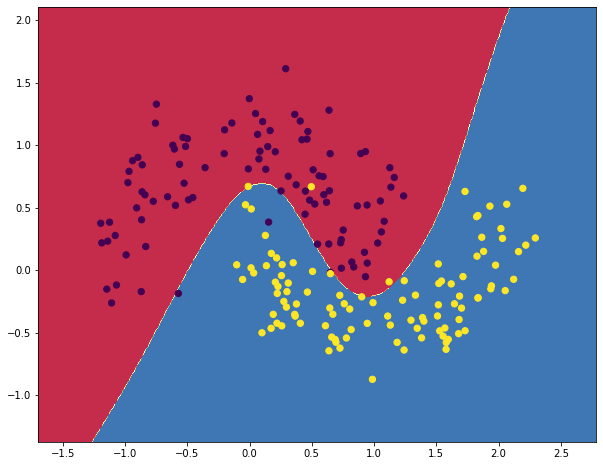

In [ ]:
# find a setting of epochs, hidden units and learning rates with better results. how do these parameters affect the results?
w,m = train(X_train, y_train, num_epochs=1000, num_hidden_nodes=10, learning_rate=10)
loss,acc = test(X_test, y_test, w, m)
print ('\ntest:',loss,acc)
plot_decision_boundary(X_test, y_test, w, m)

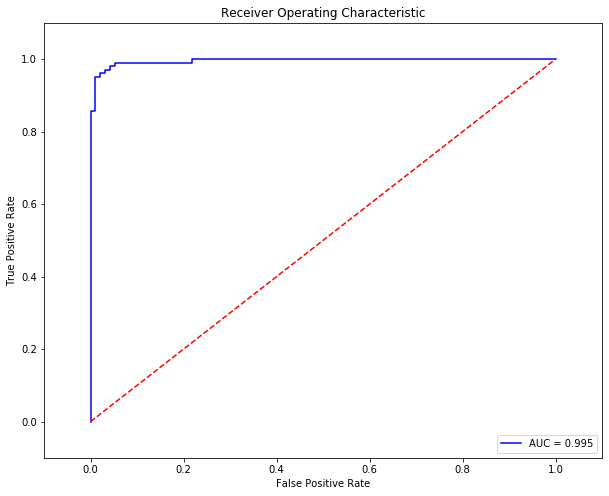

In [ ]:
#ROC and AUC
from sklearn.metrics import roc_curve, auc
# calculate the fpr and tpr for all thresholds of the classification
probs = get_probs(X_test, w, m)
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()